In [1]:
from chop.tools import get_tokenized_dataset

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True
)

/home/omar/Documents/year-4/adls/mase/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
Map: 100%|██████████| 50000/50000 [00:11<00:00, 4187.67 examples/s]


In [2]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools import get_trainer

config = AutoConfig.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_config(config)

trainer = get_trainer(
    model = model,
    tokenized_dataset = dataset,
    tokenizer = tokenizer,
    evaluate_metric = "accuracy",
    num_train_epochs = 1
)

trainer.train()

eval_results = trainer.evaluate()

baseline = eval_results["eval_accuracy"]
print(baseline)


Step,Training Loss
500,0.694100
1000,0.640100
1500,0.459500
2000,0.404300
2500,0.374900
3000,0.381300


0.84372


In [ ]:
import torch.nn as nn
from chop.nn.modules import Identity

search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices" : ["linear", "identity"]
}


In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr

track = set({})

def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)
    config.problem_type = "single_label_classification"
    ss_template = search_space

    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size"
    ]:
        chosen_idex = trial.suggest_int(param, 0, len(ss_template[param]) - 1)
        setattr(config, param, ss_template[param][chosen_idex])

    trial_model = AutoModelForSequenceClassification.from_config(config)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            track.add(name)
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                ss_template["linear_layer_choices"],
            )

            if new_layer_cls == "linear":
                continue
            elif new_layer_cls == "identity":
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unkown layer type: {new_layer_cls}")

    return trial_model

In [ ]:
from chop.tools import get_trainer

def objective(trial):
    model = construct_model(trial)

    trainer = get_trainer(
        model = model,
        tokenized_dataset = dataset,
        tokenizer = tokenizer,
        evaluate_metric = "accuracy",
        num_train_epochs = 1
    )

    trainer.train()

    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

In [ ]:
import optuna
from optuna import Study
from optuna.samplers import GridSampler, RandomSampler, TPESampler

def getGridSearchSpace():
    grid_search_space = {
        "num_layers": [i for i in range(0, len(search_space['num_layers']))],
        "num_heads": [i for i in range(0, len(search_space['num_heads']))],
        "hidden_size": [i for i in range(0, len(search_space['hidden_size']))],
        "intermediate_size": [i for i in range(0, len(search_space['intermediate_size']))],
    }

    sampler = RandomSampler()

    study = optuna.create_study(
        direction="maximize",
        study_name="bert-tiny-nas-study",
        sampler=sampler
    )

    study.optimize(
        lambda trial: construct_model(trial=trial),
        n_trials = 100,
        timeout=60*60*24
    )

    for name in track :
        grid_search_space[f'{name}_type'] = ["linear", "identity"]

    return grid_search_space


In [ ]:
# sampler = GridSampler(search_space=getGridSearchSpace()) # The sampler to use below
sampler = RandomSampler()
# sampler = TPESampler()

In [ ]:
study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler
)

study.optimize(
    objective,
    n_trials = 1,
    timeout=60*60*24
)

In [ ]:
from pathlib import Path
import dill

model = study.best_trial.user_attrs["model"].cpu()

# with open(f"{Path.home()}/mase/tasks/tutorial5/t5_best_model.pkl", "wb") as f:
    # dill.dump(model, f)

In [ ]:
from chop.pipelines import CompressionPipeline
from chop import MaseGraph

mg = MaseGraph(model)
pipe = CompressionPipeline()

quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

pruning_config = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
}

mg, _ = pipe(
    mg,
    pass_args={
        "quantize_transform_pass": quantization_config,
        "prune_transform_pass": pruning_config,
    },
)

In [ ]:
import pandas as pd
from optuna import Study
from optuna.trial import FrozenTrial

def samplerTrial(sampler_name:str, trials:int, sampler, f=objective) -> None:

    data = [0]*trials

    def record_accuracy_callback(stud:Study, fzt:FrozenTrial):
        print(f"Trial: {fzt.number}, Accuracy: {fzt.value}")
        data[fzt.number-1] ={"n":fzt.number, "accuracy":fzt.value}

    if (sampler == None):
        raise RuntimeError("No Sampler Provided")

    study = optuna.create_study(
        direction="maximize",
        study_name=f"bert-tiny-nas-{sampler_name}-study",
        sampler=sampler
    )

    study.optimize(
        f,
        n_trials=trials,
        timeout=60*60*24,
        callbacks=[record_accuracy_callback]
    )

    df = pd.DataFrame(data)
    df.to_csv(f"{Path.home()}/mase/tasks/tutorial5/sampler_run_{sampler_name}.csv", index=False)


In [ ]:
# samplerTrial(sampler_name="grid", trials=100, sampler=sampler)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np

df_r = pd.read_csv(f"{Path.cwd()}/random.csv")
df_t = pd.read_csv(f"{Path.cwd()}/tpes.csv")
df_g = pd.read_csv(f"{Path.cwd()}/grid.csv")

# Function to compute cumulative max accuracy
def compute_cumulative_max(df):
    df_sorted = df.sort_values(by='n')
    df_sorted['max_accuracy'] = np.maximum.accumulate(df_sorted['accuracy'])
    return df_sorted

# Process data
df_r = compute_cumulative_max(df_r)
df_t = compute_cumulative_max(df_t)
df_g = compute_cumulative_max(df_g)

fig_pretrain = plt.figure(dpi=200)

plt.scatter(x=df_r['n'], y=df_r['max_accuracy'] * 100, marker='x', s=20)
plt.scatter(x=df_t['n'], y=df_t['max_accuracy'] * 100, marker='x', s=20)
plt.scatter(x=df_g['n'], y=df_g['max_accuracy'] * 100, marker='x', s=20)
plt.axhline(y=baseline * 100, linestyle='--', linewidth=0.8)
lgd = plt.legend(['Random Sampler', 'TPES Sampler', 'Grid Sampler', 'Baseline'], bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel("Trials")
plt.ylabel("Accuracy %")
plt.title("Trials vs Accuracy")
# plt.savefig(f"{Path.cwd()}/samplers", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
import chop.passes as passes
from chop import MaseGraph

trials = 2

def objTrain(model, pre_evaluation=True):

    trainer = get_trainer(
        model = model,
        tokenized_dataset = dataset,
        tokenizer = tokenizer,
        evaluate_metric = "accuracy",
        num_train_epochs = 1
    )

    pre = {"eval_accuracy": 0 }

    if (pre_evaluation):
        pre = trainer.evaluate()

    trainer.train()
    eval_results = trainer.evaluate()

    return pre["eval_accuracy"], eval_results["eval_accuracy"]

data = [0] * trials

def pipeObjective(trial):
    model = construct_model(trial)

    mg = MaseGraph(
        model,
        hf_input_names=[
            "input_ids",
            "attention_mask",
            "labels"
        ]
    )

    mg, _ = passes.init_metadata_analysis_pass(mg)
    mg, _ = passes.add_common_metadata_analysis_pass(mg)

    _, post_t = objTrain(mg.model, False)

    mg.model = mg.model.cpu()
    quantization_config['by'] = "type"

    mg, _ = pipe(
            mg,
            pass_args={
                "quantize_transform_pass": quantization_config,
                "prune_transform_pass": pruning_config,
            }
        )

    post_comp_no_t, eval_acc = objTrain(mg.model)

    print(f"Trial:{trial.number}, FstTrain: {post_t}, Compressa: {post_comp_no_t}, SndTrain: {eval_acc}")

    data[trial.number] = {
        "n": trial.number,
        "fst_train": post_t,
        "compress": post_comp_no_t,
        "snd_train": eval_acc
    }

    return eval_acc

In [ ]:

study = optuna.create_study(
    direction="maximize",
    study_name=f"bert-tiny-nas-study",
    sampler=sampler
)

study.optimize(
    pipeObjective,
    # n_trials=trials,
    n_trials=1,
    timeout=60*60*24
)

df = pd.DataFrame(data)
df.to_csv(f"/vol/bitbucket/oa321/mase/tasks/tutorial5/random_cp.csv", index=False)

In [4]:
def plot(df_name:str) -> None:
    df = pd.read_csv(f"{Path.cwd()}/{df_name}.csv")


    plt.scatter(x=df['n'], y=df['fst_train'] * 100, marker='x', s=20)
    plt.scatter(x=df['n'], y=df['compress'] * 100, marker='x', s=20)
    plt.scatter(x=df['n'], y=df['snd_train'] * 100, marker='x', s=20)

    plt.axhline(y=baseline * 100, linestyle='--', linewidth=0.8)
    plt.legend(['Pre-Compress', 'After Compressing', 'Post Compress Training', 'Baseline'], bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xlabel("Trials")
    plt.ylabel("Accuracy %")
    plt.title("Trials vs Accuracy")


    plt.show()

    fig = plt.figure()

    plt.scatter(x=df['n'], y=df['fst_train'].cummax() * 100, marker='x', s=20)
    plt.scatter(x=df['n'], y=df['compress'].cummax() * 100, marker='x', s=20)
    plt.scatter(x=df['n'], y=df['snd_train'].cummax() * 100, marker='x', s=20)

    plt.axhline(y=baseline * 100, linestyle='--', linewidth=0.8)
    lgd = plt.legend(['Pre-Compress', 'After Compressing', 'Post Compress Training', 'Baseline'], bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xlabel("Trials")
    plt.ylabel("Accuracy %")
    plt.title("Trials vs Accuracy")
    plt.savefig(f"{Path.cwd()}/cp_{df_name}",  bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()



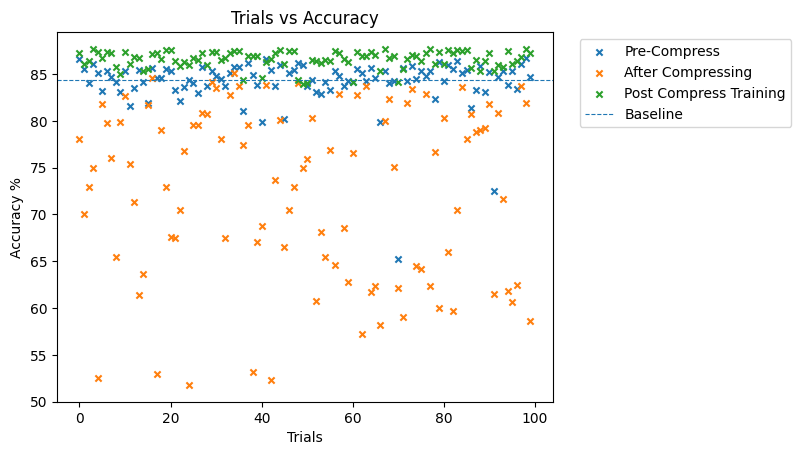

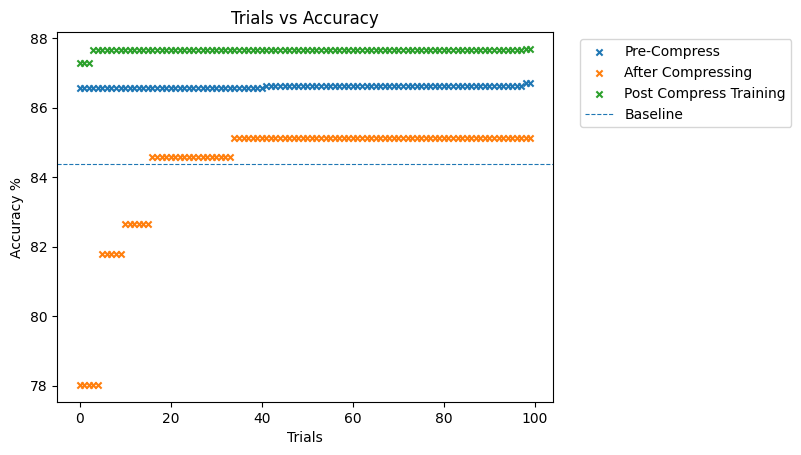

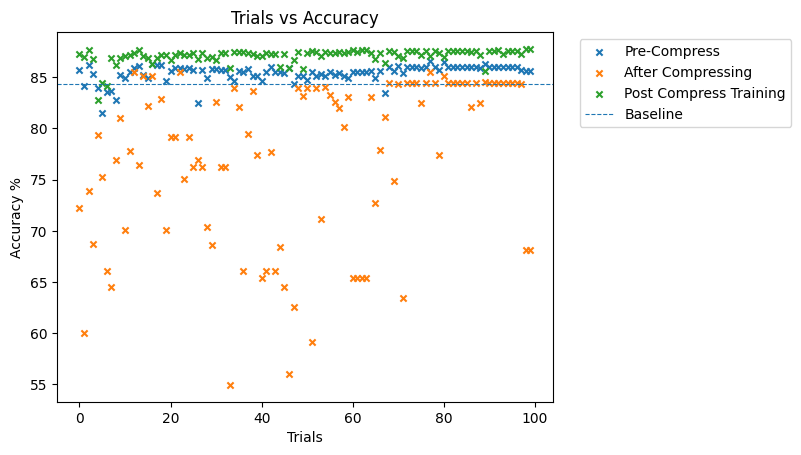

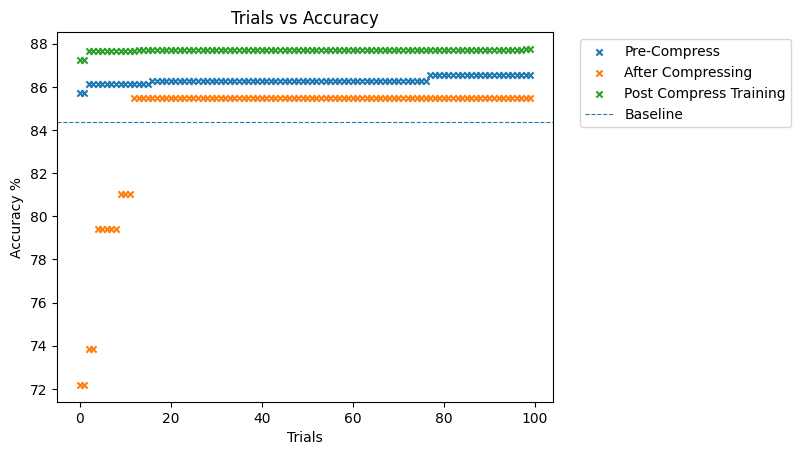

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path


plot('rand_cp')
plot('tps_cp')
